In [78]:
import pickle
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

sns.set_style("whitegrid")
# import altair as alt
# alt.renderers.enable("notebook")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")
# pd.options.display.max_rows = 4000

In [79]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
print("------------------------------------------------------------")
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
------------------------------------------------------------
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\test\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [80]:
df = pd.read_csv('cleanish_data_authors.csv')

In [81]:
df.head()

,author,id,title,publication,year,content,author.1,content_len
0,Camila Domonoske,162023,Intelligence Official: Transcripts Of Flynn’s ...,NPR,2017.0,A current U. S. intelligence official tells NP...,Camila Domonoske,3010
1,Camila Domonoske,172647,"After Fatal Police Shooting, Protest Erupts In...",NPR,2016.0,"The police shooting of a man in Charlotte, N. ...",Camila Domonoske,5740
2,Camila Domonoske,166830,Blasts In Damascus Kill At Least 45; Islamic S...,NPR,2016.0,Three explosions near a shrine revered by Shii...,Camila Domonoske,1672
3,Camila Domonoske,162911,Head Of USA Gymnastics Resigns Over Group’s Se...,NPR,2017.0,The president and CEO of USA Gymnastics has re...,Camila Domonoske,2548
4,Camila Domonoske,172312,WATCH: Bristol Motor Speedway Transformed Into...,NPR,2016.0,It took two decades to arrange a college footb...,Camila Domonoske,3101


In [82]:
df['content_full'] = df['title'] + ' ' + df['content']

In [83]:
df['content_cleaned_1'] = df['content_full'].str.replace("    ", " ")
df['content_cleaned_2'] = df['content_cleaned_1'].str.lower()

In [84]:
punctuation_signs = list("?:!.,;…“”'’\"")
df['content_cleaned_3'] = df['content_cleaned_2']

for punct_sign in punctuation_signs:
    df['content_cleaned_3'] = df['content_cleaned_3'].str.replace(punct_sign, '')

In [85]:
df['content_cleaned_4'] = df['content_cleaned_3'].str.replace("'s", "")

### Lemmatization

In [86]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [87]:
nrows = len(df)
lemmatized_text_list = []

for row in range(nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['content_cleaned_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [88]:
df['content_cleaned_5'] = lemmatized_text_list

In [89]:
%%capture
# Downloading the stop words list
nltk.download('stopwords')

In [90]:
# Loading the stop words in english
stop_words = list(stopwords.words('english')) + list(map(lambda x: x.split(' ')[0].lower(), df['author'].unique())) + ['nussbaum', 'hudson', 'jeromeehudson', 'dznussbaum', 'breitbart', 'pollak', 'joelpollock']

In [91]:
df['content_cleaned_6'] = df['content_cleaned_5']
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['content_cleaned_6'] = df['content_cleaned_6'].str.replace(regex_stopword, '')

In [92]:
df['content_cleaned_7'] = df['content_cleaned_6']
df['content_cleaned_7'] = df['content_cleaned_7'].apply(lambda x: re.sub("\s\s+", " ", x))

In [93]:
# for i in range(1,7):
#     print(i, df['Content_Parsed_{}'.format(i)].iloc[5], '\n')

In [94]:
df['content_cleaned_7'].iloc[5]

'listen carrie fisher terry gross — gary dog actress carrie fisher beloved iconic role princess leia die tuesday age 60 leave behind daughter billie lourd brother todd fisher mother debbie reynolds — french bulldog gary gary fisher celebrity right — travel widely fisher star instagram twitter carrie fisher visit nprs studios new york city talk fresh air host terry gross gary come along gross however philadelphia didnt know dog studios didnt even know allow conversation follow impossible miss buoyant personalities fishers — carrie gary ( quick look photos reveal carrie fisher wasnt lie tongue) gross ask dog gary kind famous dog use profile picture twitter hes kind dog fisher french bulldog gross oh ok fisher hes right studio gross yeah get take everywhere like — dont know usually let dog npr studio youre npr bureau new york officially therapy dog fisher yeah — know didnt get hes soothe around hes lick hand right hes nice around gross oh god hear lick hand (laughter) fisher hear gross ye

In [95]:
df = df.rename(columns={'content_cleaned_7': 'content_cleaned'})

In [96]:
list_columns = ["author", "content_full", "content_cleaned"]
df = df[list_columns]
df.head()

,author,content_full,content_cleaned
0,Camila Domonoske,Intelligence Official: Transcripts Of Flynn’s ...,intelligence official transcripts flynns call ...
1,Camila Domonoske,"After Fatal Police Shooting, Protest Erupts In...",fatal police shoot protest erupt charlotte nc...
2,Camila Domonoske,Blasts In Damascus Kill At Least 45; Islamic S...,blast damascus kill least 45 islamic state cla...
3,Camila Domonoske,Head Of USA Gymnastics Resigns Over Group’s Se...,head usa gymnastics resign group sex abuse sca...
4,Camila Domonoske,WATCH: Bristol Motor Speedway Transformed Into...,watch bristol motor speedway transform vast fo...


### Label encoding

In [97]:
df.author.unique()

array(['Camila Domonoske', 'Daniel Nussbaum', 'Jerome Hudson',
       'Joel B. Pollak'], dtype=object)

In [98]:
category_codes = {
    'Camila Domonoske': 0,
    'Daniel Nussbaum': 1,
    'Jerome Hudson': 2,
    'Joel B. Pollak': 3, 
}


In [99]:
# Category mapping
df['Category_Code'] = df['author']
df = df.replace({'Category_Code':category_codes})

In [100]:
df.head()

,author,content_full,content_cleaned,Category_Code
0,Camila Domonoske,Intelligence Official: Transcripts Of Flynn’s ...,intelligence official transcripts flynns call ...,0
1,Camila Domonoske,"After Fatal Police Shooting, Protest Erupts In...",fatal police shoot protest erupt charlotte nc...,0
2,Camila Domonoske,Blasts In Damascus Kill At Least 45; Islamic S...,blast damascus kill least 45 islamic state cla...,0
3,Camila Domonoske,Head Of USA Gymnastics Resigns Over Group’s Se...,head usa gymnastics resign group sex abuse sca...,0
4,Camila Domonoske,WATCH: Bristol Motor Speedway Transformed Into...,watch bristol motor speedway transform vast fo...,0


In [101]:
X_train, X_test, y_train, y_test = train_test_split(df['content_cleaned'], 
                                                    df['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

In [102]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [103]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1700, 300)
(300, 300)


In [104]:
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

# 'Camila Domonoske' category:
  . Most correlated unigrams:
. clinton
. trump
. associate
. report
. nprs
  . Most correlated bigrams:
. donald trump
. follow twitter

# 'Daniel Nussbaum' category:
  . Most correlated unigrams:
. actor
. star
. hollywood
. reportedly
. film
  . Most correlated bigrams:
. senior news
. twitter joelpollak

# 'Jerome Hudson' category:
  . Most correlated unigrams:
. joelpollak
. singer
. black
. foundation
. 2017
  . Most correlated bigrams:
. senior news
. twitter joelpollak

# 'Joel B. Pollak' category:
  . Most correlated unigrams:
. news
. available
. senior
. regnery
. joelpollak
  . Most correlated bigrams:
. senior news
. twitter joelpollak



In [105]:
# ['nussbaum', 'hudson', 'jeromeehudson', 'dznussbaum', 'breitbart', 'pollak', 'joelpollock']

In [106]:

import pickle
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [107]:
print(features_train.shape)
print(features_test.shape)

(1700, 300)
(300, 300)


In [108]:
features = np.concatenate((features_train,features_test), axis=0)
labels = np.concatenate((labels_train,labels_test), axis=0)

In [109]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "PCA decomposition"  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label'].astype(str)

#     category_codes = {
# }

    # Get labels name
    category_names = {
    'Camila Domonoske': 0,
    'Daniel Nussbaum': 1,
    'Jerome Hudson': 2,
    'Joel B. Pollak': 3,
    }

    # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})

    # Plot
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    palette=["red", "pink", "royalblue", "greenyellow"],
                    alpha=.7).set_title(title);


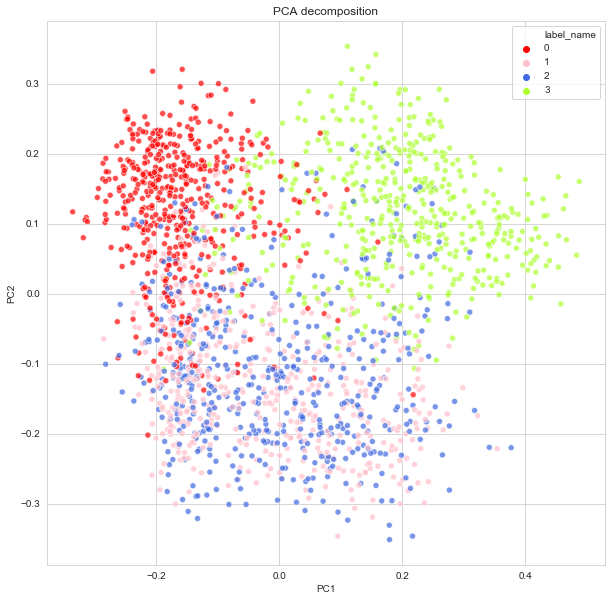

In [110]:
plot_dim_red("PCA", 
             features=features, 
             labels=labels,
             n_components=2)
plt.show()

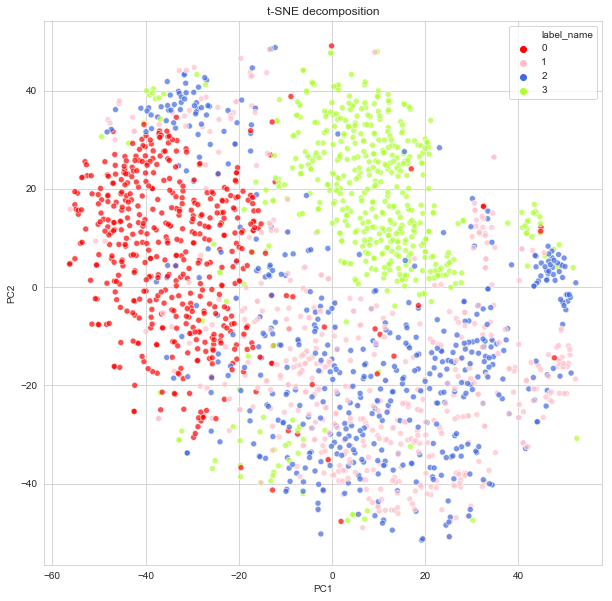

In [111]:
plot_dim_red("TSNE", 
             features=features, 
             labels=labels,
             n_components=2)
plt.show()

In [112]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import seaborn as sns
# from matplotlib import pyplot as plt
# from scipy import stats
# from scipy.stats import mode
# from scipy.stats import norm, skew #for some statistics

# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error

#ensembles
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pd.options.display.max_rows=999
pd.options.display.max_columns
# from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
# from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
# from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score
# , train_test_split
# from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter('ignore')


In [113]:
num_folds = 5
seed = 7
# scoring = 'accuracy'
scoring = 'accuracy'
# Standardize the dataset
pipelines = []
pipelines.append(('AB', AdaBoostClassifier()))
# pipelines.append(('ET', ExtraTreesClassifier()))
pipelines.append(('LDA', LinearDiscriminantAnalysis()))
pipelines.append(('XGB', XGBClassifier()))
pipelines.append(('ScaledLR', 
                  Pipeline([('Scaler', StandardScaler()),
                            ('LR',LogisticRegression())])))
pipelines.append(('ScaledLDA', 
                  Pipeline([('Scaler', StandardScaler()),
                            ('LDA', LinearDiscriminantAnalysis())])))
# pipelines.append(('ScaledKNN', 
#                   Pipeline([('Scaler', StandardScaler()),
#                             ('KNN', KNeighborsClassifier())])))

pipelines.append(('RobustScaledGBM', 
                  Pipeline([('RobustScaler', RobustScaler()),
                            ('GBM', GradientBoostingClassifier())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, features_train, labels_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.661176 (0.077469)
LDA: 0.832941 (0.014457)
XGB: 0.825294 (0.017706)
ScaledLR: 0.821765 (0.012141)
ScaledLDA: 0.832941 (0.014457)
RobustScaledGBM: 0.822941 (0.029611)


In [ ]:
# num_folds = 5
# seed = 7
# # scoring = 'accuracy'
# scoring = 'f1_macro'
# # Standardize the dataset
# pipelines = []
# pipelines.append(('AB', AdaBoostClassifier()))
# # pipelines.append(('ET', ExtraTreesClassifier()))
# pipelines.append(('LDA', LinearDiscriminantAnalysis()))
# pipelines.append(('XGB', XGBClassifier()))
# pipelines.append(('ScaledLR', 
#                   Pipeline([('Scaler', StandardScaler()),
#                             ('LR',LogisticRegression())])))
# pipelines.append(('ScaledLDA', 
#                   Pipeline([('Scaler', StandardScaler()),
#                             ('LDA', LinearDiscriminantAnalysis())])))
# # pipelines.append(('ScaledKNN', 
# #                   Pipeline([('Scaler', StandardScaler()),
# #                             ('KNN', KNeighborsClassifier())])))

# pipelines.append(('RobustScaledGBM', 
#                   Pipeline([('RobustScaler', RobustScaler()),
#                             ('GBM', GradientBoostingClassifier())])))

# results = []
# names = []
# for name, model in pipelines:
#     kfold = KFold(n_splits=num_folds, random_state=seed)
#     cv_results = cross_val_score(model, features_train, labels_train, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

In [ ]:
# num_folds = 5
# seed = 7
# # scoring = 'accuracy'
# scoring = 'precision'
# # Standardize the dataset
# pipelines = []
# pipelines.append(('AB', AdaBoostClassifier()))
# # pipelines.append(('ET', ExtraTreesClassifier()))
# pipelines.append(('LDA', LinearDiscriminantAnalysis()))
# pipelines.append(('XGB', XGBClassifier()))
# pipelines.append(('ScaledLR', 
#                   Pipeline([('Scaler', StandardScaler()),
#                             ('LR',LogisticRegression())])))
# pipelines.append(('ScaledLDA', 
#                   Pipeline([('Scaler', StandardScaler()),
#                             ('LDA', LinearDiscriminantAnalysis())])))
# # pipelines.append(('ScaledKNN', 
# #                   Pipeline([('Scaler', StandardScaler()),
# #                             ('KNN', KNeighborsClassifier())])))

# pipelines.append(('RobustScaledGBM', 
#                   Pipeline([('RobustScaler', RobustScaler()),
#                             ('GBM', GradientBoostingClassifier())])))

# results = []
# names = []
# for name, model in pipelines:
#     kfold = KFold(n_splits=num_folds, random_state=seed)
#     cv_results = cross_val_score(model, features_train, labels_train, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

In [ ]:
# num_folds = 5
# seed = 7
# # scoring = 'accuracy'
# scoring = 'recall'
# # Standardize the dataset
# pipelines = []
# pipelines.append(('AB', AdaBoostClassifier()))
# # pipelines.append(('ET', ExtraTreesClassifier()))
# pipelines.append(('LDA', LinearDiscriminantAnalysis()))
# pipelines.append(('XGB', XGBClassifier()))
# pipelines.append(('ScaledLR', 
#                   Pipeline([('Scaler', StandardScaler()),
#                             ('LR',LogisticRegression())])))
# pipelines.append(('ScaledLDA', 
#                   Pipeline([('Scaler', StandardScaler()),
#                             ('LDA', LinearDiscriminantAnalysis())])))
# # pipelines.append(('ScaledKNN', 
# #                   Pipeline([('Scaler', StandardScaler()),
# #                             ('KNN', KNeighborsClassifier())])))

# pipelines.append(('RobustScaledGBM', 
#                   Pipeline([('RobustScaler', RobustScaler()),
#                             ('GBM', GradientBoostingClassifier())])))

# results = []
# names = []
# for name, model in pipelines:
#     kfold = KFold(n_splits=num_folds, random_state=seed)
#     cv_results = cross_val_score(model, features_train, labels_train, cv=kfold, scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

# Notes:
Be sure to add pub name to stop words

In [ ]:
print('doddo')